In [1]:
# train script with logging information


# argpars 

In [2]:
from easydict import EasyDict as edict

args = edict({
    'data_dir': 'data/',
    'word_dir': 'data_mapping/',
    'window_sz': 3,
    'mfcc_dim': 13,
    'embedding_dim': 50,
    'lr': 1e-3,
    'batch_sz': 64
    'epochs': 1,
    'device': 'cpu',
    'print_itr': 10,
})

In [3]:
from model import *
from dataset import *
from tqdm.notebook import tqdm

In [4]:

model = Speech2Vec(input_dim=args.mfcc_dim, hidden_dim=args.embedding_dim, window_sz=args.window_sz)
model.to(args.device)

dataset = LibriSpeechDataset(data_dir=args.data_dir, word_dir=args.word_dir, window_sz=args.window_sz)
dataloader = DataLoader(dataset, batch_size=args.batch_sz, shuffle=True, collate_fn=dataset.pad_collate)

100%|██████████████████████████████████████████| 87/87 [00:00<00:00, 540.33it/s]

100%|██████████████████████████████████████████| 87/87 [00:00<00:00, 504.83it/s]


In [7]:

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=args.lr)

losses = []

itr = 0


train_progbar = tqdm(range(args.epochs * len(dataloader)))

for epoch in range(args.epochs):
    for batch_idx, batch in enumerate(dataloader):
        src, tgts, _, _ = batch
        src = [s.to(args.device) for s in src]
        tgts = [[t.to(args.device) for t in tgt] for tgt in tgts]

        optimizer.zero_grad()

        # pred is padded sequence
        preds = model(src, tgts)
                
        for k in range(2 * args.window_sz):
            if k == 0:
                loss = torch.zeros(1)
            # tgt likewise need to be padded sequence.
            tgt = nn.utils.rnn.pad_sequence(tgts[k])[1: ]
            loss += criterion(preds[k], tgt)

        loss.backward()
        optimizer.step()
        # TODO: Clipping to prevent gradient explosion
        nn.utils.clip_grad.clip_grad_norm(model.parameters(), max_norm=5.0)

        if (itr + 1) % args.print_itr == 0:
            loss_item = loss.item()
            losses.append(loss_item)
            train_progbar.set_description((f"Epoch: {round(epoch + batch_idx / len(dataloader), 3)} | " \
                                          f"Loss: {round(loss_item, 3)}"))
            train_progbar.refresh()
        
        
        # TODO: DELETE LINES
        if itr == 500:
            break
            
        train_progbar.update()
        itr += 1
    
    # evaluation code could be added here
    



Epoch: 0.082 | Loss: 415.169:   8%|▊         | 279/3286 [04:31<48:43,  1.03it/s]
/Users/yjang43/miniconda3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/yjang43/miniconda3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/var/folders/8m/f9qyvdm50px677r3f__7st4h0000gn/T/ipykernel_53560/680819819.py:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad.clip_grad_norm(model.parameters(), max_norm=5.0)

  0%|                                          | 9/3286 [00:02<14:41,  3.72it/s]
Epoch: 0.003 | Loss: 402.444:   0%|            | 9/3286 [00:02<14:41,  3.72it/s]
Epoch: 0

In [ ]:

from logging import getLogger


logger = getLogger('log/logger')

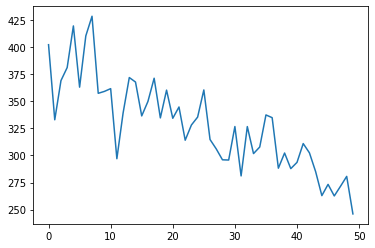

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)